# Import Dataset

In [ ]:
#upload kaggle.json downloaded under kaggle account
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#download datasets from surface crack detection
! kaggle datasets download arunrk7/surface-crack-detection
! unzip surface-crack-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: Positive/15001_1.jpg    
  inflating: Positive/15002_1.jpg    
  inflating: Positive/15003_1.jpg    
  inflating: Positive/15004_1.jpg    
  inflating: Positive/15005_1.jpg    
  inflating: Positive/15006_1.jpg    
  inflating: Positive/15007_1.jpg    
  inflating: Positive/15008_1.jpg    
  inflating: Positive/15009_1.jpg    
  inflating: Positive/15010_1.jpg    
  inflating: Positive/15011_1.jpg    
  inflating: Positive/15012_1.jpg    
  inflating: Positive/15013_1.jpg    
  inflating: Positive/15014_1.jpg    
  inflating: Positive/15015_1.jpg    
  inflating: Positive/15016_1.jpg    
  inflating: Positive/15017_1.jpg    
  inflating: Positive/15018_1.jpg    
  inflating: Positive/15019_1.jpg    
  inflating: Positive/15020_1.jpg    
  inflating: Positive/15021_1.jpg    
  inflating: Positive/15022_1.jpg    
  inflating: Positive/15023_1.jpg    
  inflating: Positive/15024_1.jpg    
  inflating: Positive/15025_1.jpg    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import modules

In [ ]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet152V2, VGG16, VGG19
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter("ignore")

# Preparing Data and building DataFrame

In [ ]:
# Turn the directory paths into Path object
positive_dir = Path('/content/Positive/')
negative_dir = Path('/content/Negative/')


In [ ]:
def generate_df(image_dir, label):
    """
    Create the DataFrame of the associated directory and label.
    """

    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)

    return df


positive_df = generate_df(positive_dir, 'POSITIVE')
negative_df = generate_df(negative_dir, 'NEGATIVE')
data = pd.concat([positive_df, negative_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
data.head()

,Filepath,Label
0,/content/Negative/06442.jpg,NEGATIVE
1,/content/Positive/15536_1.jpg,POSITIVE
2,/content/Negative/03414.jpg,NEGATIVE
3,/content/Positive/03848.jpg,POSITIVE
4,/content/Negative/18428.jpg,NEGATIVE


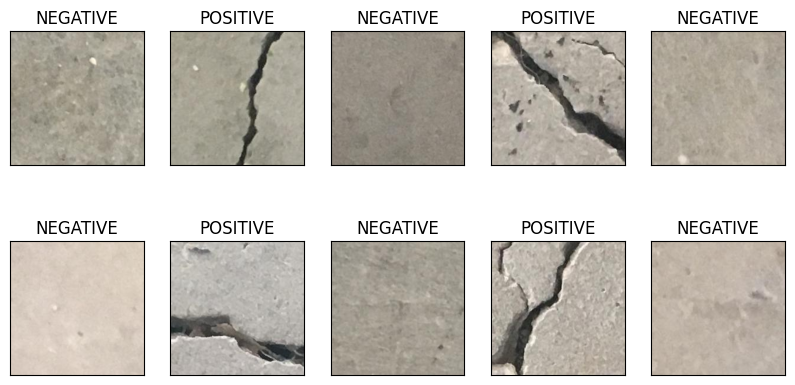

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])

In [ ]:
# Split Training and Test sets
train_df, test_df = train_test_split(
    data.sample(6000, random_state=1), # Keep only 6000 samples to save computation time.
    train_size=0.7,
    shuffle=True,
    random_state=42)

# Loading Image Data & Data Preprocessing

In [ ]:
# Image generator for the training set
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
)

# Image generator for the test set
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
)

# Generate training images
train_images = train_generator.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(227, 227),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

# Generate validation images
val_images = train_generator.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(227, 227),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Generate test images
test_images = test_generator.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(227, 227),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


# Model Building and Training

In [ ]:
# Create the layers
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.Sequential()
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [ ]:
# Create the Sequential Convolutional Neural Network (SCNN)
SCNN = tf.keras.Model(inputs=inputs, outputs=outputs)
SCNN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 32)                0   

In [ ]:
# Compile SCNN
SCNN.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Build Model
def build_model(base_model):
    base_model.trainable = False
    inputs = Input(shape=(227, 227, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

In [ ]:
# Dict of pre-trained models
models = {
    "ResNet50": ResNet50,
    "ResNet50V2": ResNet50V2,
    "ResNet152V2": ResNet152V2,
    "VGG16": VGG16,
    "VGG19": VGG19,
}

In [ ]:
# Compile Models
compiled_models = {}
for model_name, model_architecture in models.items():
    base = model_architecture(include_top=False, weights='imagenet')
    compiled_models[model_name] = build_model(base)
    compiled_models[model_name].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Add SCNN to compiled models dict
compiled_models.update({"SCNN": SCNN})

In [ ]:
# Train and Validate
history_data = {}
for model_name, model in compiled_models.items():
    print(f"Training {model_name}...")
    history = model.fit(train_images, validation_data=val_images, epochs=100,
                        callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                min_delta=0.0002,
                                patience=3,
                                mode='min',
                                verbose=1,
                                baseline=None,
                                restore_best_weights=True
                                )
                            ]
                        )
    history_data[model_name] = history

Training ResNet50...
Epoch 1/100
105/105 [==============================] - 22s 167ms/step - loss: 1.7820 - accuracy: 0.5211 - val_loss: 0.6928 - val_accuracy: 0.5310
Epoch 2/100
105/105 [==============================] - 18s 168ms/step - loss: 0.6929 - accuracy: 0.5152 - val_loss: 0.6925 - val_accuracy: 0.5310
Epoch 3/100
105/105 [==============================] - 17s 162ms/step - loss: 0.6928 - accuracy: 0.5152 - val_loss: 0.6923 - val_accuracy: 0.5310
Epoch 4/100
105/105 [==============================] - 16s 154ms/step - loss: 0.6928 - accuracy: 0.5152 - val_loss: 0.6922 - val_accuracy: 0.5310
Epoch 5/100
105/105 [==============================] - 16s 155ms/step - loss: 0.6928 - accuracy: 0.5152 - val_loss: 0.6921 - val_accuracy: 0.5310
Epoch 6/100
105/105 [==============================] - 16s 152ms/step - loss: 0.6927 - accuracy: 0.5152 - val_loss: 0.6920 - val_accuracy: 0.5310
Epoch 7/100
105/105 [==============================] - 17s 159ms/step - loss: 0.6927 - accuracy: 0.5152

# Model Comparison

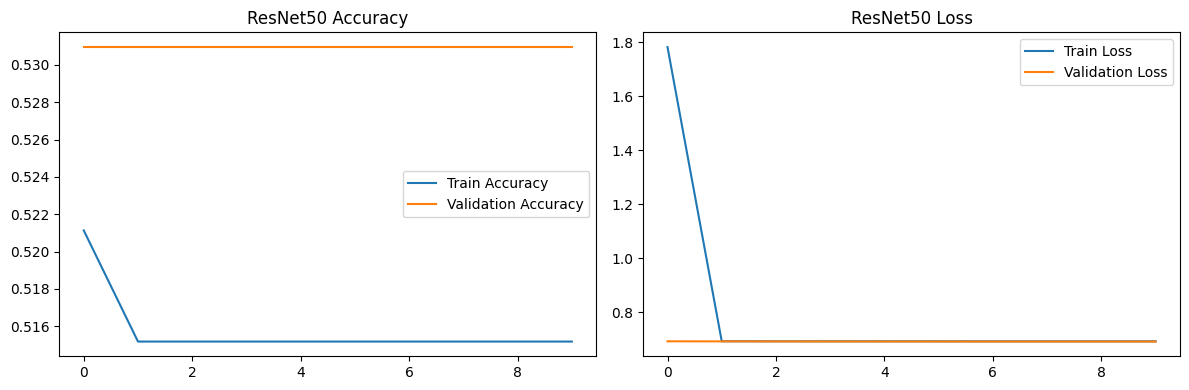

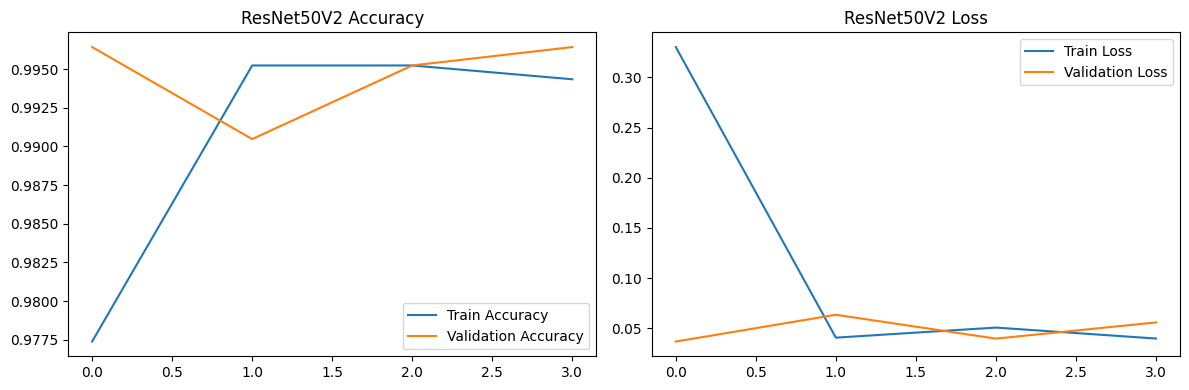

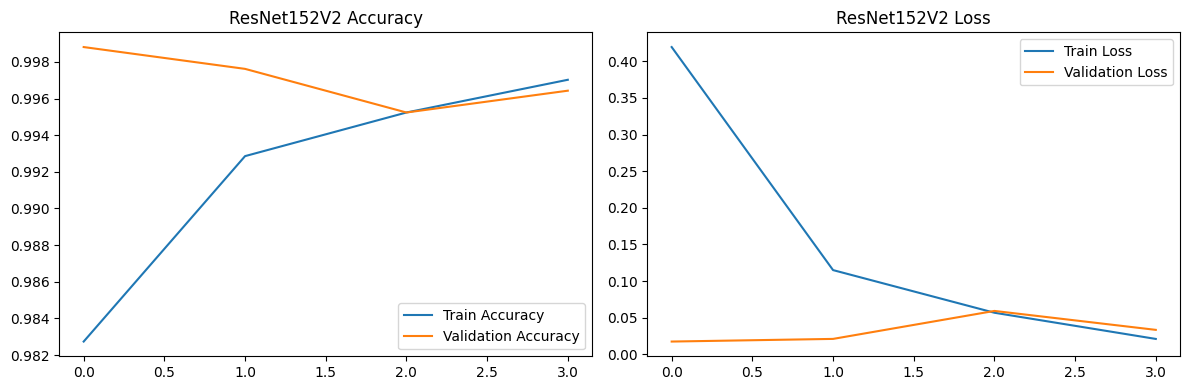

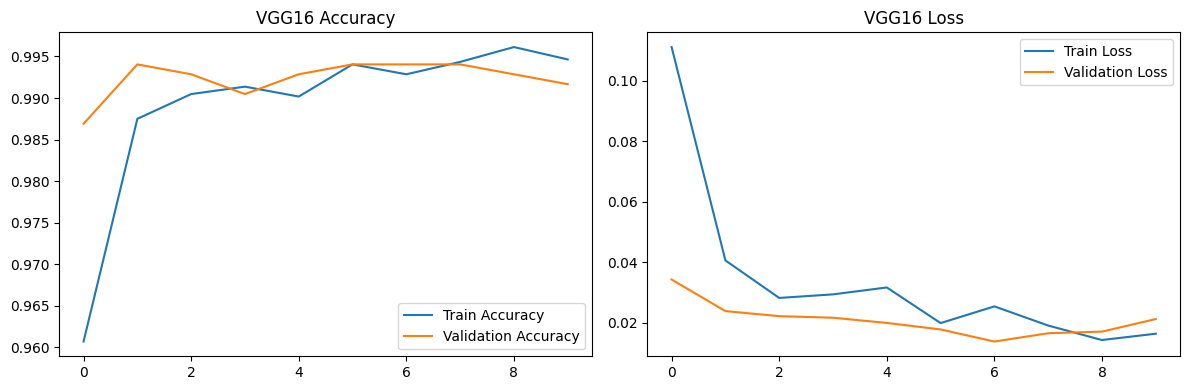

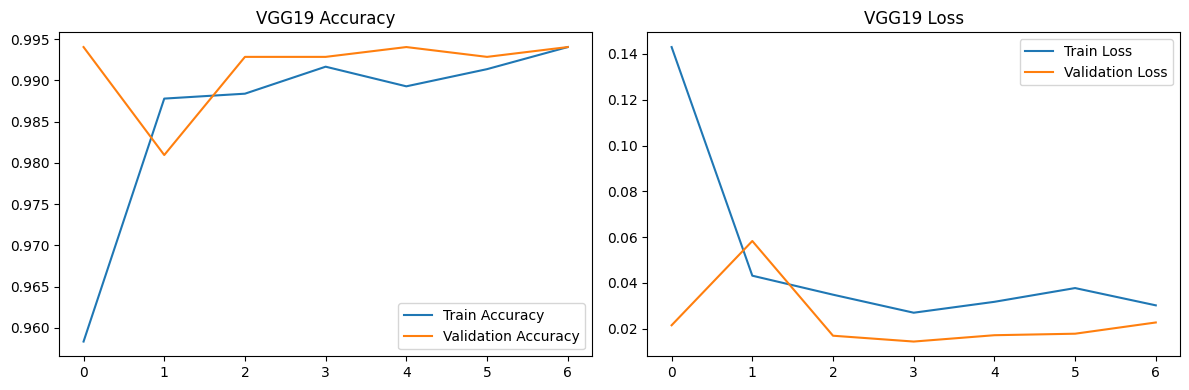

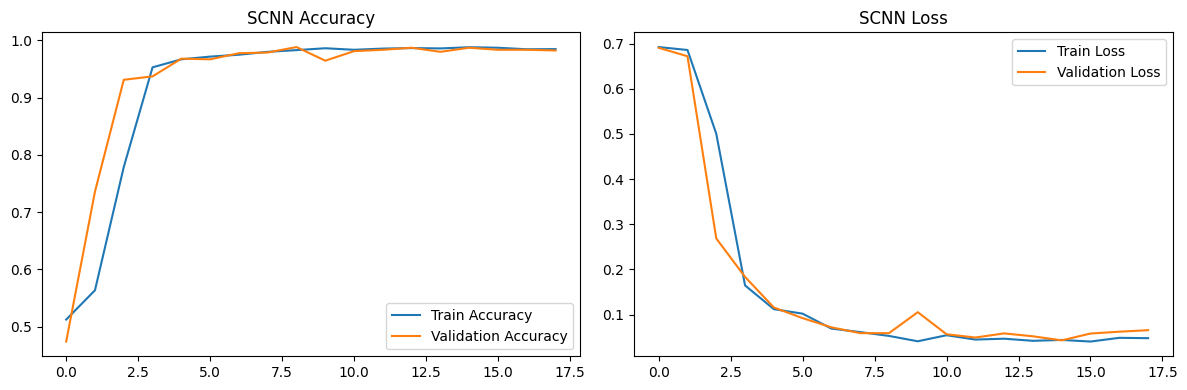

In [ ]:
# Model comparison by plotting the training accuracy and loss for comparison
for model_name, history in history_data.items():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Results

In [ ]:
def evaluate_model(model):

    results = model.evaluate(test_images, verbose=0)
    loss = results[0]
    acc = results[1]

    print("Test Loss: {:.5f}".format(loss))
    print("Accuracy: {:.2f}%".format(acc * 100))

    cm = confusion_matrix(test_images.labels, y_pred)
    clr = classification_report(test_images.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("Classification Report:\n------------------------------\n", clr)

In [ ]:
for model_name, model in compiled_models.items():
  y_pred = (model.predict(test_images).squeeze() >= 0.5).astype(int)

57/57 [==============================] - 2s 42ms/step


Test Loss: 0.69441
Accuracy: 48.28%


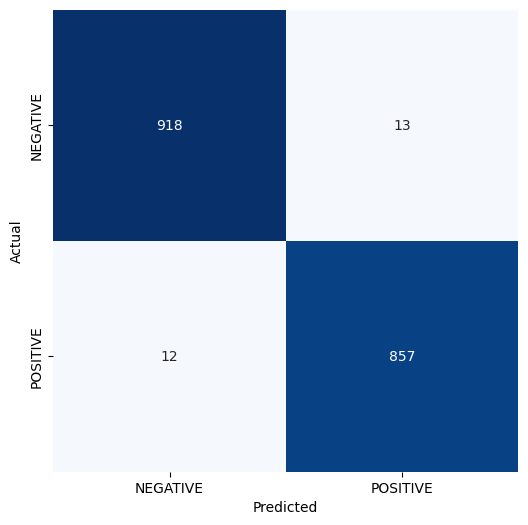

Classification Report:
------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.99      0.99       931
    POSITIVE       0.99      0.99      0.99       869

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800

Test Loss: 0.01790
Accuracy: 99.72%


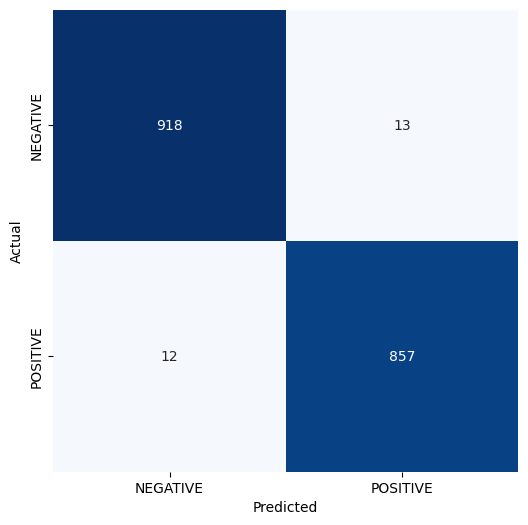

Classification Report:
------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.99      0.99       931
    POSITIVE       0.99      0.99      0.99       869

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800

Test Loss: 0.05147
Accuracy: 99.61%


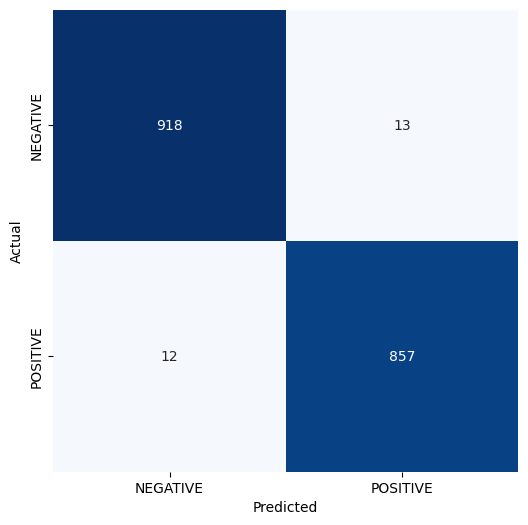

Classification Report:
------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.99      0.99       931
    POSITIVE       0.99      0.99      0.99       869

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800

Test Loss: 0.01931
Accuracy: 99.39%


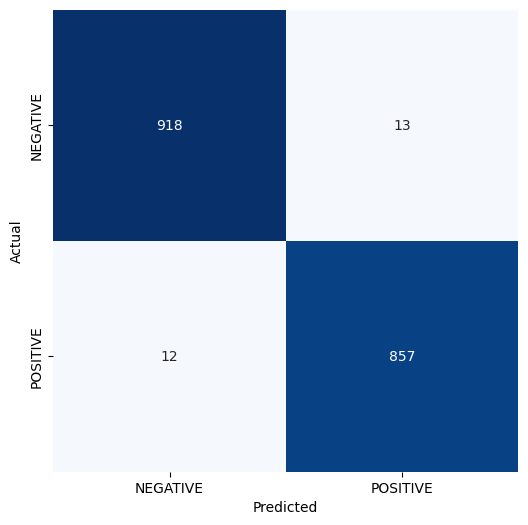

Classification Report:
------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.99      0.99       931
    POSITIVE       0.99      0.99      0.99       869

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800

Test Loss: 0.02222
Accuracy: 99.22%


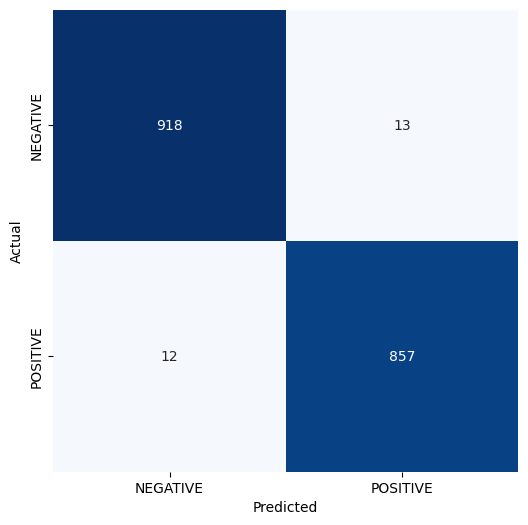

Classification Report:
------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.99      0.99       931
    POSITIVE       0.99      0.99      0.99       869

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800

Test Loss: 0.05193
Accuracy: 98.61%


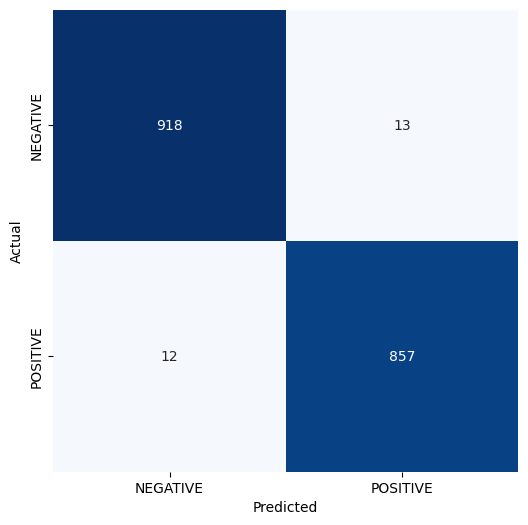

Classification Report:
------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.99      0.99       931
    POSITIVE       0.99      0.99      0.99       869

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



In [ ]:
for model_name, model in compiled_models.items():
  evaluate_model(model)

In [ ]:
# Select model with highest accuracy score to do classification prediction
y_pred = (compiled_models.get("ResNet50V2").predict(test_images).squeeze() >= 0.5).astype(int)

57/57 [==============================] - 6s 99ms/step


# Results Output

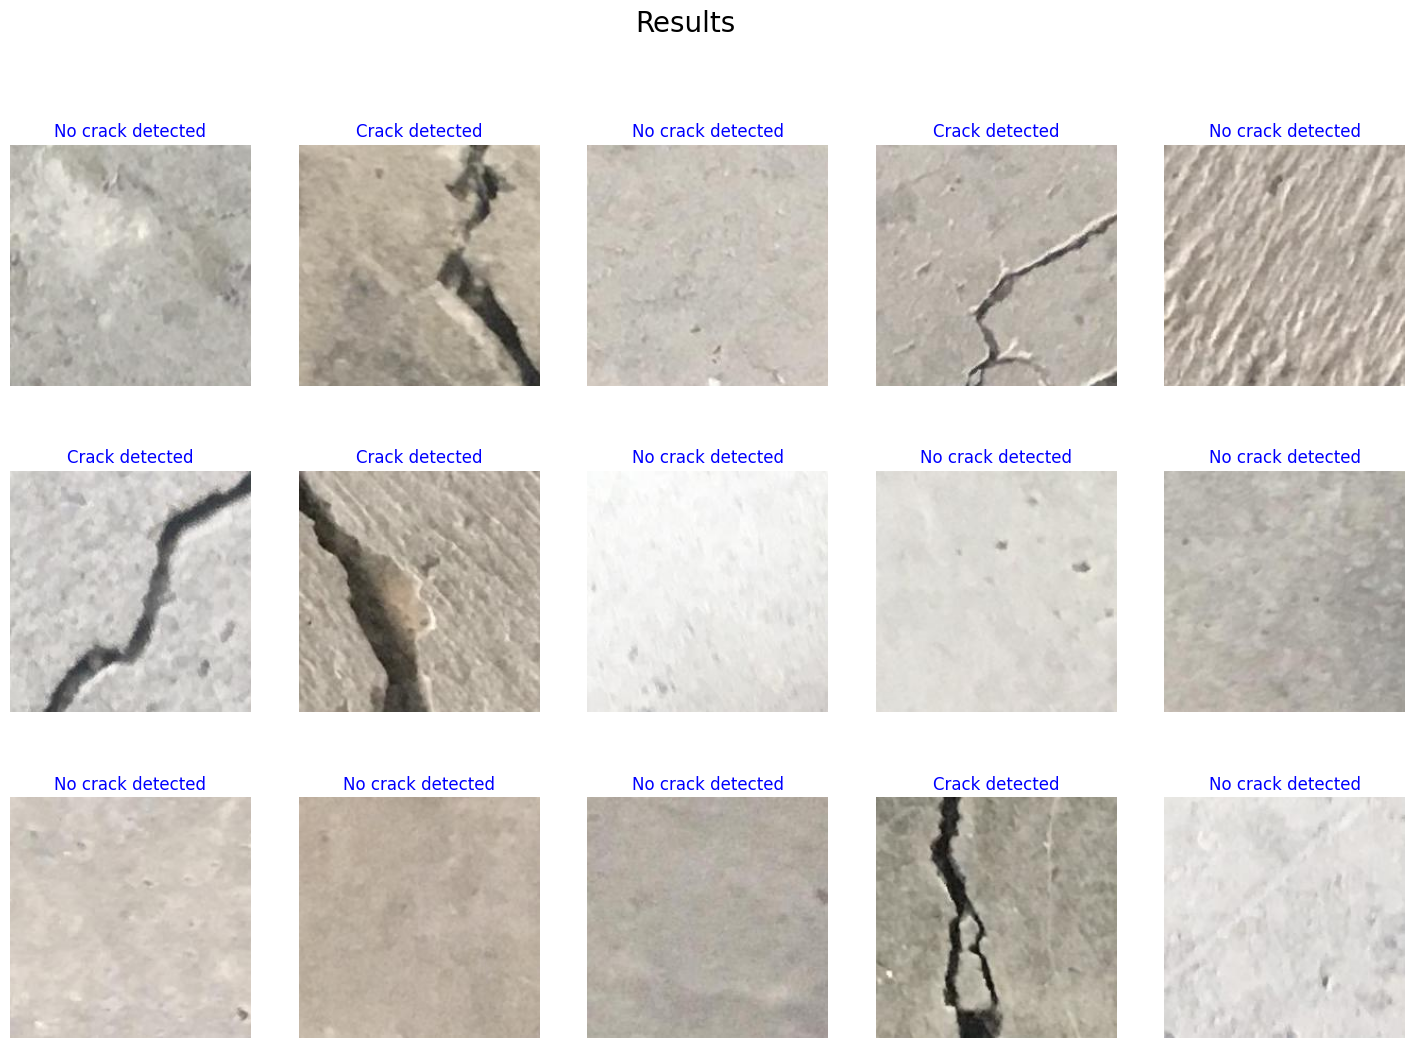

In [ ]:
plt.figure(figsize=(18, 12))

for i in range(15):

    plt.subplot(3, 5, i+1)
    plt.imshow(test_images[0][0][i])
    plt.title("No crack detected" if y_pred[i] == 0 else "Crack detected",
              color='blue' if y_pred[i] == test_images.labels[i] else 'red')
    plt.axis('off')

plt.suptitle("Results", fontsize=20)
plt.show()

# Mistakes made by Model

In [ ]:
mistake_idx = (y_pred != test_images.labels).nonzero()[0]
print(len(mistake_idx), "mistakes.")
print("Indices:", mistake_idx)

5 mistakes.
Indices: [ 565 1040 1145 1162 1761]


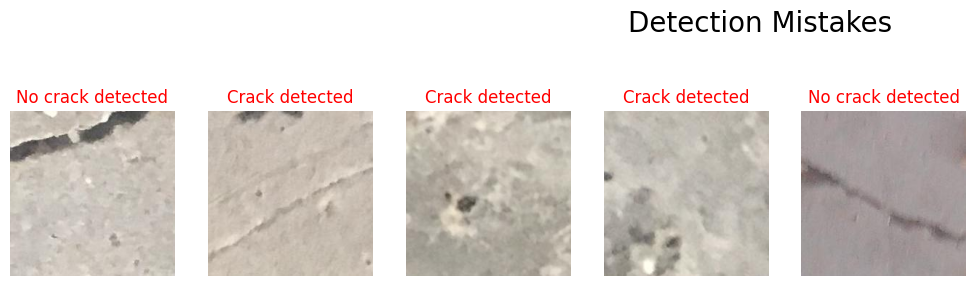

In [ ]:
# Display the detection mistakes
plt.figure(figsize=(20, 10))

for i, idx in enumerate(mistake_idx):

    # Get batch number and image number (batch of 32 images)
    batch = idx // 32
    image = idx % 32

    plt.subplot(4, 8, i+1)
    plt.imshow(test_images[batch][0][image])
    plt.title("No crack detected" if y_pred[idx] == 0 else "Crack detected", color='red')
    plt.axis('off')

plt.suptitle("Detection Mistakes", fontsize=20)
plt.show()